In [3]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# for handling and parsing email files
import email
import os
import re
import nltk
from email import message_from_string
from email.message import EmailMessage

from wordcloud import WordCloud
from bs4 import BeautifulSoup
from collections import Counter
# modeling
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score
from sklearn.metrics import classification_report, precision_score, recall_score, accuracy_score, confusion_matrix, f1_score, roc_curve, auc

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from email.parser import BytesParser
from email import policy
from sklearn.feature_selection import SelectKBest, chi2, RFE, SelectFromModel
from sklearn.linear_model import LassoCV
from sklearn.ensemble import RandomForestClassifier


In [4]:
from google.colab import files

# Create a file upload button.
uploaded = files.upload()

Saving ham_zipped.zip to ham_zipped.zip
Saving spam_zipped.zip to spam_zipped.zip


In [5]:
!unzip -q spam_zipped.zip -d /content/spam_emails
!unzip -q ham_zipped.zip -d /content/ham_emails

In [6]:
!ls /content/ham_emails
!ls /content/spam_emails

ham_zipped  __MACOSX
__MACOSX  spam_zipped


In [7]:
# Function to read emails from a directory
def read_files(directory):
    emails = []
    for filename in os.listdir(directory):
        filepath = os.path.join(directory, filename)
        try:
            with open(filepath, 'r', encoding='utf-8') as file:
                emails.append(file.read())
        except UnicodeDecodeError:
            try:
                with open(filepath, 'r', encoding='latin1') as file:
                    emails.append(file.read())
            except Exception as e:
                print(f"Failed to read {filepath} with both UTF-8 and Latin1: {str(e)}")
    return emails

In [8]:
# Reading emails from both directories
ham_emails = read_files('/content/ham_emails/ham_zipped/main_ham')
spam_emails = read_files('/content/spam_emails/spam_zipped/main_spam')

Number of ham files: 6951
Number of spam files: 2398
Spam to Ham ratio: 0.34498633290174074
Spam percentage:  25.64980211787357 %


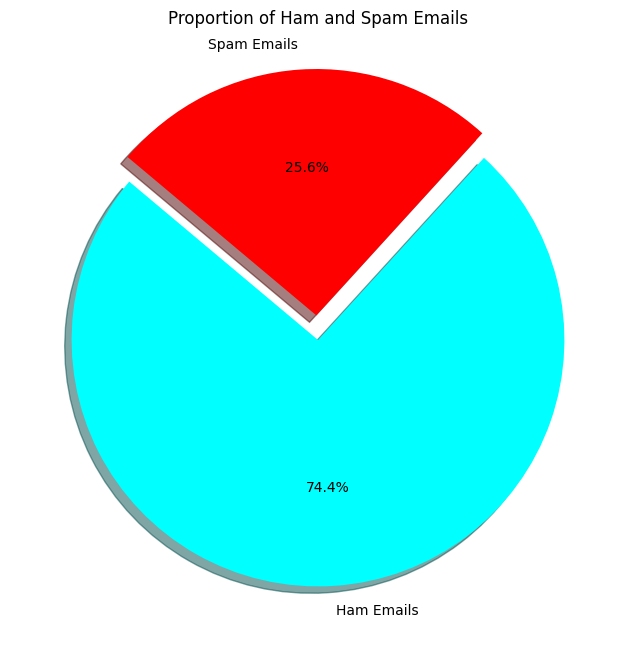

In [9]:
# Label the emails
ham_labels = [0] * len(ham_emails)
spam_labels = [1] * len(spam_emails)

# Combine the emails and labels
emails = ham_emails + spam_emails
labels = ham_labels + spam_labels

# Proportion of Ham and Spam Emails
hl, sl = len(ham_emails), len(spam_emails)

print("Number of ham files:", hl)
print("Number of spam files:", sl)
print("Spam to Ham ratio:", sl/hl)
print("Spam percentage: ", (sl / (sl + hl)) * 100, "%")

plt.figure(figsize=(8, 8))
sizes = [hl, sl]
colors = ['cyan', 'red']
explode = (0, 0.1)

plt.pie(sizes, explode=explode, labels=['Ham Emails', 'Spam Emails'], colors=colors, autopct='%1.1f%%',
        shadow=True, startangle=140)
plt.title('Proportion of Ham and Spam Emails')
plt.show()

In [10]:
#Extracting Email Content
def extract_email_body(filepath):
    with open(filepath, 'rb') as file:
        email = BytesParser(policy=policy.default).parse(file)
    if email.is_multipart():
        for part in email.walk():
            ctype = part.get_content_type()
            if ctype in ('text/plain', 'text/html'):
                content = part.get_payload(decode=True).decode('latin1', errors='ignore')
                return content.lower()
    else:
        return email.get_payload(decode=True).decode('latin1', errors='ignore').lower()

def read_and_process_emails(directory):
    emails = []
    for filename in os.listdir(directory):
        filepath = os.path.join(directory, filename)
        email_body = extract_email_body(filepath)
        emails.append(email_body)
    return emails

ham_emails = read_and_process_emails('/content/ham_emails/ham_zipped/main_ham')
spam_emails = read_and_process_emails('/content/spam_emails/spam_zipped/main_spam')


In [11]:
# Convert the text data to numerical features
vectorizer = TfidfVectorizer(max_features=3000)
X = vectorizer.fit_transform(ham_emails + spam_emails).toarray()
y = np.array([0] * len(ham_emails) + [1] * len(spam_emails))

In [12]:
# Function to evaluate the model
def evaluate_model(X, y, num_features, feature_selector, classifier='NB', k=None):
    if feature_selector == 'Pearson':
        cor_list = []
        for i in range(X.shape[1]):
            cor = np.corrcoef(X[:, i], y)[0, 1]
            cor_list.append(cor)
        selected_features = np.argsort(np.abs(cor_list))[-num_features:]
    elif feature_selector == 'Chi-Square':
        chi2_selector = SelectKBest(chi2, k=num_features)
        selected_features = chi2_selector.fit(X, y).get_support(indices=True)

    X_selected = X[:, selected_features]
    scaler = MinMaxScaler()
    X_normalized = scaler.fit_transform(X_selected)

    X_train, X_test, y_train, y_test = train_test_split(X_normalized, y, test_size=0.3, random_state=42)

    if classifier == 'NB':
        model = GaussianNB()
    elif classifier == 'KNN':
        model = KNeighborsClassifier(n_neighbors=k)

    model.fit(X_train, y_train)
    predictions = model.predict(X_test)

    accuracy = accuracy_score(y_test, predictions)
    precision = precision_score(y_test, predictions)
    recall = recall_score(y_test, predictions)
    f1 = f1_score(y_test, predictions)

    conf_matrix = confusion_matrix(y_test, predictions)
    if classifier == 'NB':
        predictions_proba = model.predict_proba(X_test)[:, 1]
    else:
        predictions_proba = model.predict_proba(X_test)[:, 1]

    fpr, tpr, _ = roc_curve(y_test, predictions_proba)
    roc_auc = auc(fpr, tpr)

    return accuracy, precision, recall, f1, conf_matrix, fpr, tpr, roc_auc

In [13]:
# Evaluate model with different feature selection methods and number of features for Naive Bayes
feature_methods = ['Pearson', 'Chi-Square']
num_features_list = [2, 5, 10, 20, 50, 100]
results_nb = {method: [] for method in feature_methods}

for method in feature_methods:
    for num_features in num_features_list:
        accuracy, precision, recall, f1, conf_matrix, fpr, tpr, roc_auc = evaluate_model(X, y, num_features, method, classifier='NB')
        results_nb[method].append(accuracy)
        print(f'{method} with {num_features} features (NB): Accuracy = {accuracy:.2f}')


Pearson with 2 features (NB): Accuracy = 0.82
Pearson with 5 features (NB): Accuracy = 0.83
Pearson with 10 features (NB): Accuracy = 0.84
Pearson with 20 features (NB): Accuracy = 0.90
Pearson with 50 features (NB): Accuracy = 0.91
Pearson with 100 features (NB): Accuracy = 0.93
Chi-Square with 2 features (NB): Accuracy = 0.83
Chi-Square with 5 features (NB): Accuracy = 0.83
Chi-Square with 10 features (NB): Accuracy = 0.83
Chi-Square with 20 features (NB): Accuracy = 0.85
Chi-Square with 50 features (NB): Accuracy = 0.91
Chi-Square with 100 features (NB): Accuracy = 0.93


In [14]:
# Display the results for Naive Bayes in a table
results_nb_df = pd.DataFrame(results_nb, index=num_features_list)
results_nb_df.index.name = 'Number of Features'
print(results_nb_df)

                     Pearson  Chi-Square
Number of Features                      
2                   0.821034    0.833512
5                   0.832442    0.826738
10                  0.839572    0.834938
20                  0.895544    0.853832
50                  0.906595    0.913369
100                 0.925490    0.931194


In [15]:
# Evaluate model with different feature selection methods using 20 features for KNN
k_values = [3, 5, 7, 9]
results_knn = {method: [] for method in feature_methods}

for method in feature_methods:
    for k in k_values:
        accuracy, precision, recall, f1, conf_matrix, fpr, tpr, roc_auc = evaluate_model(X, y, 20, method, classifier='KNN', k=k)
        results_knn[method].append(accuracy)
        print(f'{method} with 20 features (KNN, k={k}): Accuracy = {accuracy:.2f}')

# Display the results for KNN in a table
results_knn_df = pd.DataFrame(results_knn, index=k_values)
results_knn_df.index.name = 'k'
print(results_knn_df)


Pearson with 20 features (KNN, k=3): Accuracy = 0.96
Pearson with 20 features (KNN, k=5): Accuracy = 0.95
Pearson with 20 features (KNN, k=7): Accuracy = 0.95
Pearson with 20 features (KNN, k=9): Accuracy = 0.95
Chi-Square with 20 features (KNN, k=3): Accuracy = 0.93
Chi-Square with 20 features (KNN, k=5): Accuracy = 0.93
Chi-Square with 20 features (KNN, k=7): Accuracy = 0.93
Chi-Square with 20 features (KNN, k=9): Accuracy = 0.92
    Pearson  Chi-Square
k                      
3  0.955437    0.930481
5  0.954011    0.931194
7  0.952228    0.927629
9  0.947950    0.920143


In [26]:
# Confusion Matrix and ROC Curve- 20 features using Pearson for KNN with k=5)
_, _, _, _, conf_matrix, fpr, tpr, roc_auc = evaluate_model(X, y, 20, 'Pearson', classifier='KNN', k=5)


In [27]:
# Confusion Matrix and ROC Curve for KNN (20 features using Pearson, k=5)
accuracy, precision, recall, f1, conf_matrix_knn, fpr_knn, tpr_knn, roc_auc_knn = evaluate_model(X, y, 20, 'Pearson', classifier='KNN', k=5)

print(f'KNN (Pearson, 20 features, k=5) - Accuracy: {accuracy:.2f}, Precision: {precision:.2f}, Recall: {recall:.2f}, F1 Score: {f1:.2f}')

KNN (Pearson, 20 features, k=5) - Accuracy: 0.95, Precision: 0.94, Recall: 0.88, F1 Score: 0.91


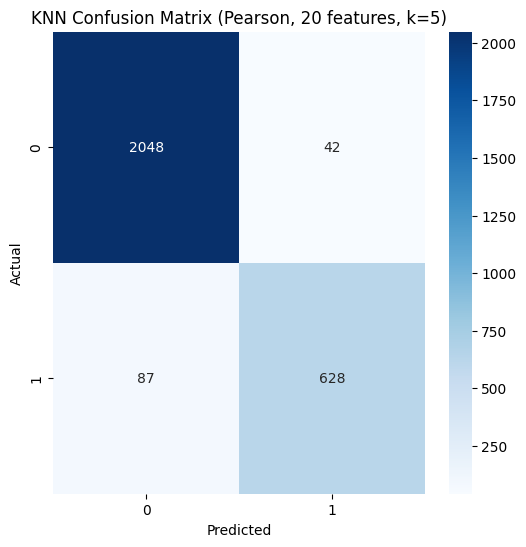

In [17]:
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('KNN Confusion Matrix (Pearson, 20 features, k=5)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

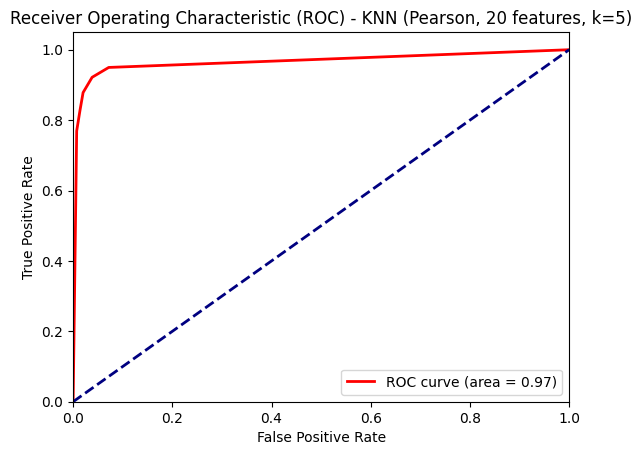

In [18]:
plt.figure()
plt.plot(fpr, tpr, color='red', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) - KNN (Pearson, 20 features, k=5)')
plt.legend(loc="lower right")
plt.show()

In [20]:
# Confusion Matrix and ROC Curve - 20 features using Pearson for NB
_, _, _, _, conf_matrix, fpr, tpr, roc_auc = evaluate_model(X, y, 20, 'Pearson', classifier='NB')

In [28]:
# Confusion Matrix and ROC Curve for Naive Bayes (20 features using Pearson)
accuracy, precision, recall, f1, conf_matrix_nb, fpr_nb, tpr_nb, roc_auc_nb = evaluate_model(X, y, 20, 'Pearson', classifier='NB')

print(f'Naive Bayes (Pearson, 20 features) - Accuracy: {accuracy:.2f}, Precision: {precision:.2f}, Recall: {recall:.2f}, F1 Score: {f1:.2f}')


Naive Bayes (Pearson, 20 features) - Accuracy: 0.90, Precision: 0.81, Recall: 0.77, F1 Score: 0.79


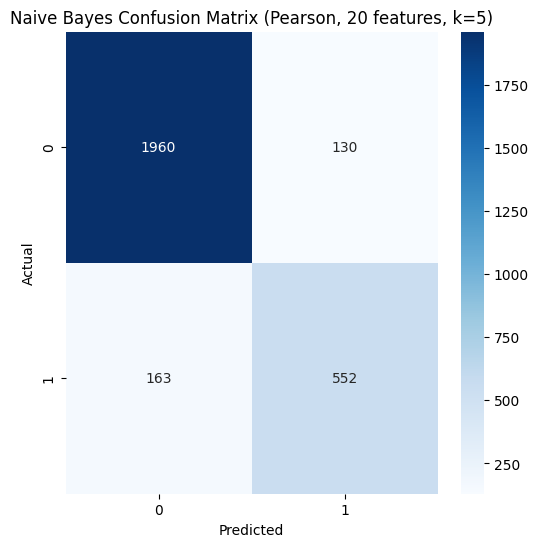

In [21]:
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Naive Bayes Confusion Matrix (Pearson, 20 features, k=5)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

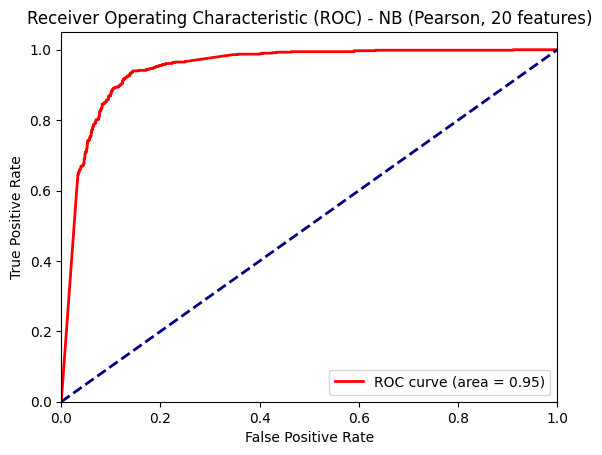

In [22]:
plt.figure()
plt.plot(fpr, tpr, color='red', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) - NB (Pearson, 20 features)')
plt.legend(loc="lower right")
plt.show()